# WISE Young Stellar Object Variability Analysis
WISE 관측 데이터를 이용한 원시성의 밝기변화 시계열 데이터 분석 프로젝트입니다.  

## 1. 원시성 데이터 수집 및 가공
프로젝트의 첫 단계로, WISE 우주망원경 데이터베이스에서 원시성 관측 데이터를 추출 및 가공하는 과정입니다.

by Wooseok Park  
ref: https://ui.adsabs.harvard.edu/abs/2021ApJ...920..132P/abstract

In [1]:
import numpy as np
import pandas as pd
import pyvo
import matplotlib.pyplot as plt

In [2]:
from decimal import Decimal, ROUND_HALF_UP, ROUND_HALF_EVEN

# define and use original round rather than using python round
def my_round(in_number, ndigits=0, rounding_rule=1):
    """rounding_rule==1: ROUND_HALF_UP, Round to nearest, ties away from zero
       rounding_rule==2: ROUND_HALF_EVEN, Round to nearest, ties to even """
    # make float expression
    if ndigits > 0:
        expression = '0.' + '0' * ndigits
        number = in_number
    else:  # 0 or negative
        expression = '0'
        number = in_number / (10 ** (-ndigits))

    # round by rounding rule
    if rounding_rule == 2:
        round_number = Decimal(number).quantize(Decimal(expression), rounding=ROUND_HALF_EVEN)
    else:
        round_number = Decimal(number).quantize(Decimal(expression), rounding=ROUND_HALF_UP)

    # return number
    if ndigits > 0:
        return float(round_number)
    else:  # 0 or negative
        return int(round_number * (10 ** (-ndigits)))

NASA InfraRed Science Archive (IRSA)는 미 항공우주국 NASA의 적외선 관측 데이터를 열람할 수 있는 아카이브 센터입니다. IRSA는 VO Table Access Protocol (TAP) 이라는 api를 제공하며 이를 통해 원하는 좌표의 관측 데이터를 쿼리를 통해 추출할 수 있습니다.  

여기에서는 원시성 중 하나인 [IRAS 05403-1026](https://simbad.cds.unistra.fr/simbad/sim-id?Ident=%408608654&Name=IRAS%2005403-1026&submit=submit) (아래 이미지의 cyan 동그라미 내)의 WISE 관측 데이터를 추출하고 가공해 보겠습니다.

![yso1.png](../readme_images/yso_05403.png)

In [3]:
# TAP 쿼리로 데이터 추출. RA, Dec 입력
service = pyvo.dal.TAPService('https://irsa.ipac.caltech.edu/TAP')
result = service.run_async("""
           SELECT mjd, w1mag, w1sigm, w2mag, w2sigm, qual_frame, ra, dec
           FROM neowiser_p1bs_psd
           WHERE CONTAINS(POINT('ICRS',ra, dec), CIRCLE('ICRS',85.677833333, -10.41925,3/3600))=1
    """)
tab = result.to_table().to_pandas()
tab

,mjd,w1mag,w1sigm,w2mag,w2sigm,qual_frame,ra,dec
0,57818.558416,8.890,0.008,7.560,0.007,10,85.677866,-10.419328
1,56730.463521,8.687,0.006,7.397,0.006,10,85.677830,-10.419337
2,56730.331853,8.737,0.006,7.473,0.006,10,85.677841,-10.419363
3,56730.068392,8.901,0.006,7.545,0.006,10,85.677871,-10.419321
4,56730.002558,8.873,0.006,7.578,0.006,10,85.677855,-10.419353
...,...,...,...,...,...,...,...,...
236,59474.620293,8.416,0.008,7.228,0.007,10,85.677853,-10.419329
237,59474.751069,8.471,0.008,7.236,0.007,10,85.677847,-10.419329
238,59474.881718,8.639,0.010,7.197,0.015,10,85.677853,-10.419294
239,59475.012494,8.506,0.008,7.291,0.007,5,85.677849,-10.419324


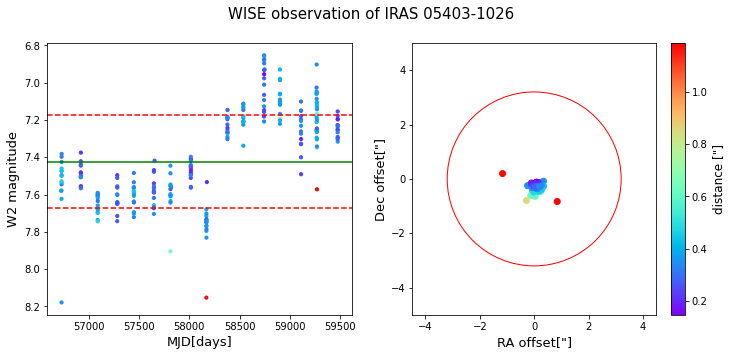

In [4]:
RA = 85.677833333
DEC = -10.41925
dist = np.sqrt(
    (tab.ra - RA)**2 + (tab.dec - DEC)**2
  )*3600  #distance from catalogue position


# W2 lightcurve

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].scatter(tab.mjd,tab.w2mag,c=dist, cmap='rainbow', s=10)
ax[0].invert_yaxis()
ax[0].set_xlabel('MJD[days]',size=13)
ax[0].set_ylabel('W2 magnitude',size=13)

# plot mean, std of brightness
ax[0].axhline(tab.w2mag.median(), color='g')
ax[0].axhline(tab.w2mag.median() + tab.w2mag.std(), color='r', linestyle='--')
ax[0].axhline(tab.w2mag.median() - tab.w2mag.std(), color='r', linestyle='--')

# W2 datapoint ra/dec distance plot
dist_plot = ax[1].scatter((tab.ra-RA)*3600, (tab.dec-DEC)*3600, c=dist, cmap='rainbow')

circ1 = plt.Circle((0,0), 
                  6.4/2, # WISE W2 angular resolution : 6.4 arcsec. Deg = arcsec/3600 ≈ arcsec*0.0002778
                  color='r',
                  fill=False)
cbar2 = plt.colorbar(dist_plot)#,cax=axc1)
cbar2.ax.set_ylabel('distance ["]',size=12)
ax[1].axis('equal')
ax[1].add_artist(circ1)
ax[1].set_xlim(-5, 5) 
ax[1].set_ylim(-5, 5)
# ax.invert_xaxis()
# ax.ticklabel_format(useOffset=False)
ax[1].set_xlabel('RA offset["]',size=13)
ax[1].set_ylabel('Dec offset["]',size=13)
# dist_std = np.std(np.sqrt(radist**2+decdist**2)*3600)
# print(f'STD distance from center is : {dist_std:.3f}"')

plt.suptitle('WISE observation of IRAS 05403-1026', size=15)
plt.show()

이렇게 원시성 IRAS 05403-1026의 WISE 밝기 데이터를 query로 가져와 시간에 따른 밝기변화(왼쪽) 및 공간상 관측된 위치(오른쪽)로 나타내었습니다.  
- WISE 우주망원경이 지구를 공전하며 한 천체를 6개월마다 관측하기 때문에 왼쪽 그래프에서 관측값 datapoint 무리들 간 180일(6개월)의 날짜 차를 보이고 있습니다
- 녹색 실선은 밝기의 중앙값, 빨간 점선은 중앙값으로부터 $\pm$ 1sigma (표준편차)를 나타냅니다. 각 점의 색은 기준 좌표로부터의 거리를 나타냅니다. 
- 오른쪽 동그라미는 기준 좌표로부터 탐색된 반지름 3"의 범위를 나타냅니다. 기준좌표에서 반지름 3" 내로 검색을 수행했기 때문에, 밝기 데이터는 모두 동그라미 내에 위치하고 있습니다.

#### 수집한 RAW 데이터에서는 여러 **문제**가 보여지고 있습니다.  

1. 밝기의 중앙값인 녹색 선과 1sigma 범위인 빨간 점선을 고려하였을때 이를 벗어나는 개별 datapoint가 매우 많습니다.
2. 이 중에는 왼쪽 plot에서 다른 관측치들과 비교해 매우 떨어져 있어 오류로 보여지는 outlier 데이터가 있고, 그 중에는 빨간 점과 같이 다른 datapoint에 비해 많이 떨어져 있는 공간적 outlier (다른 원시성,혹은 근처 타 천체로 인한 light pollution일 가능성 있음)가 존재합니다.
3. 180일 (6개월) 마다 관측을 하다보니 6개월에 한번씩 20포인트가 수 시간~수 일에 걸쳐 몰려 있는 아주 특이한 time grid를 가지고 있으며, 이 때문에 fitting 및 feature 계산을 어렵게 합니다. 
4. 개별 datapoint가 한 관측(6개월마다) 때 측정값들이 꽤 퍼져 있습니다. 원시성이 수 시간~수 일에 걸쳐 중적외선 밝기가 빠르게 변화하는 것은 매우 드물기 때문에 datapoint 하나하나를 완전히 신뢰할 수 없습니다.

#### 이러한 문제들을 해결하기 위해 데이터를 다음과 같이 가공하였습니다.
1. 공간상의 outlier을 제거하기 위해 기준점으로부터 각 datapoint까지 거리의 평균, 표준편차($\sigma$)를 구하고  
평균으로부터 거리 $2\sigma$ 이하의 datapoint만 사용합니다.


Text(0.5, 1.0, 'Lightcurve - spatial outliers removed')

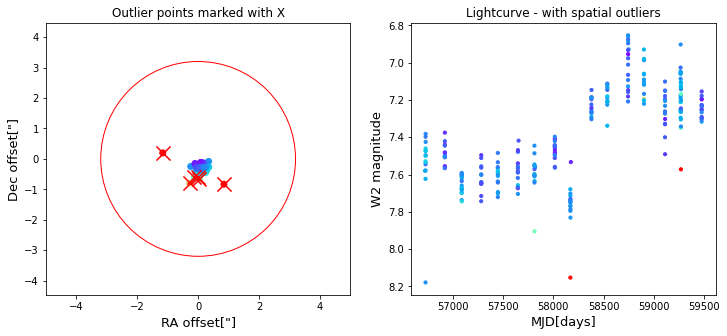

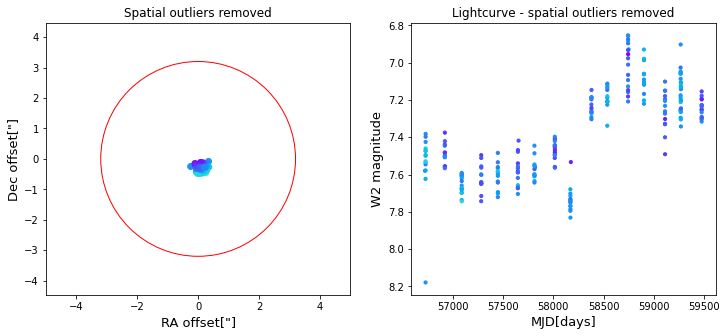

In [5]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

# plot outliers
outliers = tab.loc[dist[(dist < dist.mean() - 2*dist.std()) |\
     (dist > dist.mean() + 2*dist.std())].index
     ]

circ2 = plt.Circle((0,0), 
                  6.4/2, # WISE W2 angular resolution : 6.4 arcsec. Deg = arcsec/3600 ≈ arcsec*0.0002778
                  color='r',
                  fill=False, )
ax[0].scatter((tab.ra-RA)*3600, (tab.dec-DEC)*3600, c=dist, cmap='rainbow')
ax[0].scatter((outliers.ra-RA)*3600, (outliers.dec-DEC)*3600, marker='x', c='r', s=200)
ax[0].axis('equal')
ax[0].set_xlim(-5, 5) 
ax[0].set_ylim(-5, 5)
ax[0].add_artist(circ2)

ax[0].set_title('Outlier points marked with X')
ax[0].set_xlabel('RA offset["]',size=13)
ax[0].set_ylabel('Dec offset["]',size=13)

ax[1].scatter(tab.mjd, tab.w2mag, 
          c=dist, cmap='rainbow', s=10)
ax[1].invert_yaxis()
ax[1].set_xlabel('MJD[days]',size=13)
ax[1].set_ylabel('W2 magnitude',size=13)
ax[1].set_title('Lightcurve - with spatial outliers')

# lightcurve without spatial outliers
tab_spout = tab.drop(outliers.index, axis=0)

fig2, ax2 = plt.subplots(1, 2, figsize=(12,5))

circ3 = plt.Circle((0,0), 
                  6.4/2, # WISE W2 angular resolution : 6.4 arcsec. Deg = arcsec/3600 ≈ arcsec*0.0002778
                  color='r',
                  fill=False)
s3 = ax2[0].scatter((tab_spout.ra-RA)*3600,(tab_spout.dec-DEC)*3600, c=dist.drop(outliers.index, axis=0), cmap='rainbow')
s3.set_clim([dist.min(), dist.max()])
ax2[0].axis('equal')
ax2[0].set_xlim(-5, 5) 
ax2[0].set_ylim(-5, 5)
ax2[0].add_artist(circ3)
ax2[0].set_title('Spatial outliers removed')
ax2[0].set_xlabel('RA offset["]',size=13)
ax2[0].set_ylabel('Dec offset["]',size=13)

s2 = ax2[1].scatter(tab_spout.mjd, tab_spout.w2mag, 
          c=dist.drop(outliers.index, axis=0),
          cmap='rainbow', s=10)
s2.set_clim([dist.min(), dist.max()])
ax2[1].invert_yaxis()
ax2[1].set_xlabel('MJD[days]',size=13)
ax2[1].set_ylabel('W2 magnitude',size=13)
ax2[1].set_title('Lightcurve - spatial outliers removed')

위와 같이 공간상의 outlier을 제거했을때 밝기 변화 lightcurve에서의 outlier도 일부 제거됨을 확인할 수 있습니다.


2. 6개월마다 관측한 datapoint들 (<U>특정 시점에 모여 있는 점들</U>)을 한 그룹으로 묶고 해당 그룹에서 $1\sigma$ 이상 밝기 차이를 보이는 datapoint를 outlier로 간주, 제거합니다. 한 그룹의 datapoint들은 밝기변화가 정규분포를 따른다고 가정했을 때 밝기변화 범위 중 16%-84% 를 $1\sigma$ 범위로 설정할 수 있습니다.   

3. time grid를 균일하게 하기 위해 2.에서 outlier 제거한 그룹 당 밝기 값을 모두 평균하여 한 datapoint로 만들고 그룹 내 밝기변화 표준편차를 datapoint 오차로 지정합니다. 



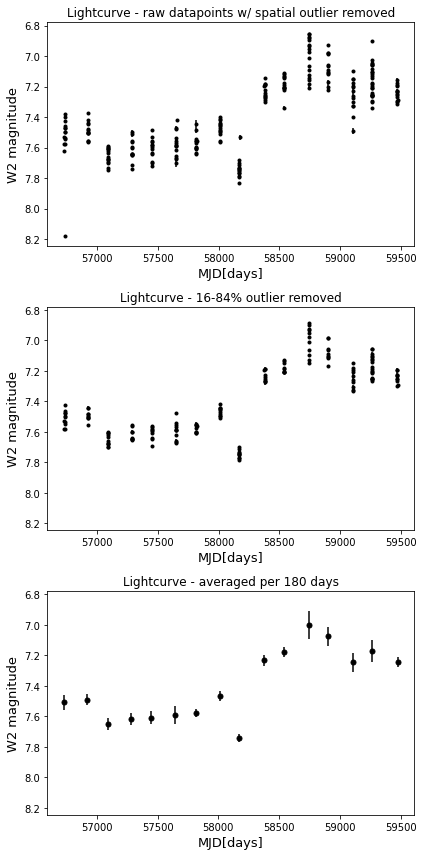

In [6]:
# datapoint를 +- 100일 범위로 그룹화하기
tab_group = tab_spout.copy().sort_values('mjd').reset_index(drop=True) # 날짜 순으로 정렬
tab_group['group'] = 0 # 그룹 데이터 생성
jd = tab_group['mjd']
gnum = 1
group_first_date = tab_group['mjd'][0]
for i in tab_group.index[:-1]:
    if jd[i] + 100 < jd[i+1]: # 다음 관측일이 100일보다 이후일 때 - 앞 데이터들에 그룹 숫자 부여
        tab_group.loc[(jd >= group_first_date) & (jd < jd[i+1]), 'group'] = gnum
        group_first_date = jd[i+1]
        gnum += 1
    # 마지막 그룹에 숫자 부여
    tab_group.loc[jd >= group_first_date, 'group'] = gnum


# 16%-84% 범위 벗어나는 outlier 제거 및 그룹 별 한 datapoint로 average
gr_list = []
gr_avg_list = []
for i in tab_group['group'].unique():
    # outlier removed data
    gr = tab_group.loc[tab_group['group'] == i]
    gr = gr.sort_values('w2mag').reset_index(drop=True)
    gr = gr.iloc[my_round(len(gr)*0.16) : my_round(len(gr)*0.84)] # choose only 16%-84% magnitude
    gr_list.append(gr)

    # averaged per one group
    gr_avg = pd.Series({'mjd':gr['mjd'].mean(), 'w2mag':gr['w2mag'].mean(),
                        'w2sigm':np.sqrt(gr['w2sigm'].mean()**2 + gr['w2mag'].std()**2)})
    gr_avg_list.append(gr_avg)

df_cut = pd.concat(gr_list).sort_values('mjd').reset_index(drop=True) # outlier removed 
df_avg = pd.concat(gr_avg_list,axis=1).T # outlier removed + averaged per one group


# lightcurve, outlier removed, averaged plot - total 3 plots
fig, ax = plt.subplots(3,1,figsize=(6,12), sharey=True)

ax[0].errorbar(tab_group['mjd'], tab_group['w2mag'], tab_group['w2sigm'], fmt='k.')
ax[1].errorbar(df_cut['mjd'], df_cut['w2mag'], df_cut['w2sigm'], fmt='k.')
ax[2].errorbar(df_avg['mjd'], df_avg['w2mag'], df_avg['w2sigm'], fmt='k.',ms=10)

for i in range(len(ax)):
    ax[i].invert_yaxis()
    ax[i].set_xlabel('MJD[days]',size=13)
    ax[i].set_ylabel('W2 magnitude',size=13)

ax[0].set_title('Lightcurve - raw datapoints w/ spatial outlier removed')
ax[1].set_title('Lightcurve - 16-84% outlier removed')
ax[2].set_title('Lightcurve - averaged per 180 days')

plt.tight_layout()
plt.show()

상단 마지막 그래프는 위의 방식으로 전처리한 균일한 간격의 time-series 데이터를 보여줍니다.  
이러한 방법으로 약 **5400개**의 원시성 데이터를 관측 아카이브에서 데이터를 수집하고 raw 관측 데이터를 분석에 용이하게 가공하였습니다.

다음 노트북에서는 가공된 관측 데이터를 이용하여 통계적 feature을 생성하고, 밝기 변화의 형태 및 기준을 정의하도록 하겠습니다.

In [11]:
# save the results
tab_group.to_csv('example_data/ex1_tab.csv', index=None)
df_cut.to_csv('example_data/ex1_cut.csv', index=None)
df_avg.to_csv('example_data/ex1_avg.csv', index=None)
